In [ ]:
import tejapi
tejapi.ApiConfig.api_key = "Your Key"
tejapi.ApiConfig.api_base = "Your Base"
data = tejapi.get('GLOBAL/ANMAR', mdate={'gte':'2000-01-01', 'lte':'2025-04-09'}, coid = 'EA1101')
data.sort_values('mdate')

data2 = tejapi.get('TWN/AAPRCDA', coid = ['0050'], mdate={'gte':'2000-01-01', 'lte':'2025-04-09'})
df_price = data2[['mdate','close_d', 'avgclsd']].copy()
data3 = tejapi.get('TWN/AAPRCDA', coid = ['00865B'], mdate={'gte':'2000-01-01', 'lte':'2025-04-09'})
df_bond = data3[['mdate','close_d', 'avgclsd']].copy()

data['mdate'] = pd.to_datetime(data['mdate'])
data['val_shifted'] = data['val'].shift(1) 
df_price['mdate'] = pd.to_datetime(df_price['mdate'])
df_bond['mdate'] = pd.to_datetime(df_bond['mdate'])


data = data.set_index('mdate', drop=False)
df_price = df_price.set_index('mdate', drop=False)
df_bond = df_bond.set_index('mdate', drop=False)

df_P_daily = data.resample('D').ffill()


df = df_price.join(df_P_daily, how = 'left', rsuffix='_P')
df = df.join(df_bond, how = 'left', rsuffix='_bond')
df['mdate'] = df['mdate'].dt.strftime('%Y-%m-%d')
df['mdate'] = pd.to_datetime(df['mdate'])

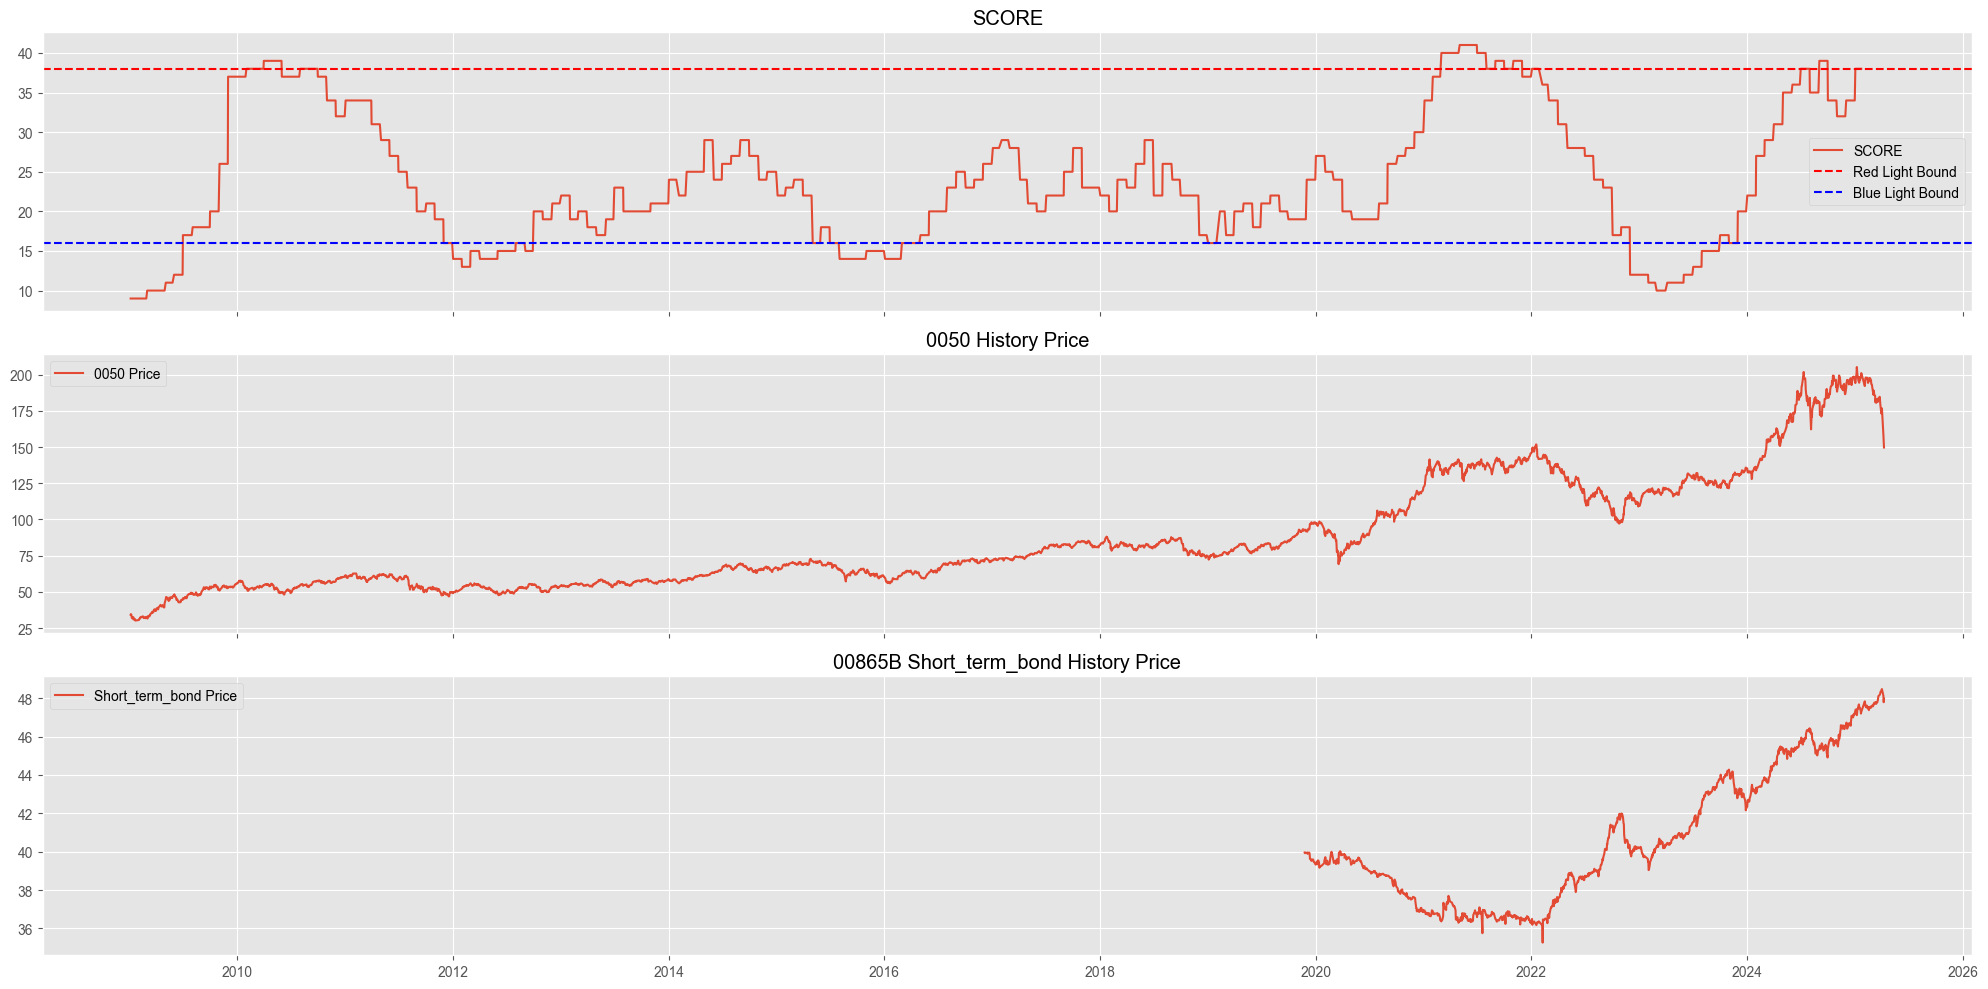

In [ ]:
import pandas as pd

#df = pd.read_csv('eco_data.csv')
df['mdate'] = pd.to_datetime(df['mdate'])
df['mdate'] = df['mdate'].dt.strftime('%Y-%m-%d')
df['mdate'] = pd.to_datetime(df['mdate'])


import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
plt.style.use('ggplot')
axes[1].plot(df['mdate'], df['avgclsd'], label = '0050 Price')
axes[1].set_title(f'0050 History Price')
axes[1].legend()

axes[0].plot(df['mdate'], df['val_shifted'], label = 'SCORE')
axes[0].axhline(y = 38, label = 'Red Light Bound', color = 'red', linestyle = '--')
axes[0].axhline(y= 16, label = 'Blue Light Bound', color = 'blue', linestyle = '--')
axes[0].set_title(f'SCORE')
axes[0].legend()

axes[2].plot(df['mdate'], df['avgclsd_bond'], label = 'Short_term_bond Price')
axes[2].set_title(f'00865B Short_term_bond History Price')
axes[2].legend()

plt.tight_layout()
plt.show()

In [137]:
import os
import tejapi
plt.rcParams['font.family'] = 'Arial'
tej_key = 'SZf1BjNEcKQhvQmn96eLrNL60Q2RH1'
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = tej_key

from zipline.data.run_ingest import simple_ingest
from zipline.api import set_slippage, set_commission, set_benchmark,  symbol,  record
from zipline.api import order_target_percent, order_percent, order
from zipline.api import set_long_only, set_max_leverage


from zipline.finance import commission, slippage
from zipline import run_algorithm
pool = ['0050', 'IR0001', '00865B', '00687B','00664R']
start_date = '2009-01-01'
end_date = '2025-04-09'
start_ingest = start_date.replace('-', '')
end_ingest = end_date.replace('-', '')

simple_ingest(name = 'tquant' , tickers = pool , start_date = start_ingest , end_date = end_ingest)

print(pool)

Now ingesting data.


[2025-04-16 08:31:44.752887] INFO: zipline.data.bundles.core: Ingesting tquant.


Merging daily equity files:
Currently used TEJ API key call quota 156/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 536202/9223372036854775807 (0.0%)


[2025-04-16 08:31:47.523122] INFO: zipline.data.bundles.core: Ingest tquant successfully.


End of ingesting tquant.
Please call function `get_bundle(start_dt = pd.Timestamp('20090101', tz = 'utc'),end_dt = pd.Timestamp('20250409' ,tz = 'utc'))` in `zipline.data.data_portal` to check data.
Currently used TEJ API key call quota 156/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 536202/9223372036854775807 (0.0%)
['0050', 'IR0001', '00865B', '00687B', '00664R']


進入景氣循環
Date: 2020-01-02, Score: 27.0, 買進 0050
Date: 2021-02-26, Score: 40.0, 賣出 0050
Date: 2021-02-26, Score: 40.0，買入債券避險
Date: 2022-11-30, Score: 12.0, 買進 0050
Date: 2022-11-30, Score: 12.0，賣出債券
Date: 2024-06-28, Score: 38.0, 賣出 0050
Date: 2024-06-28, Score: 38.0，買入債券避險


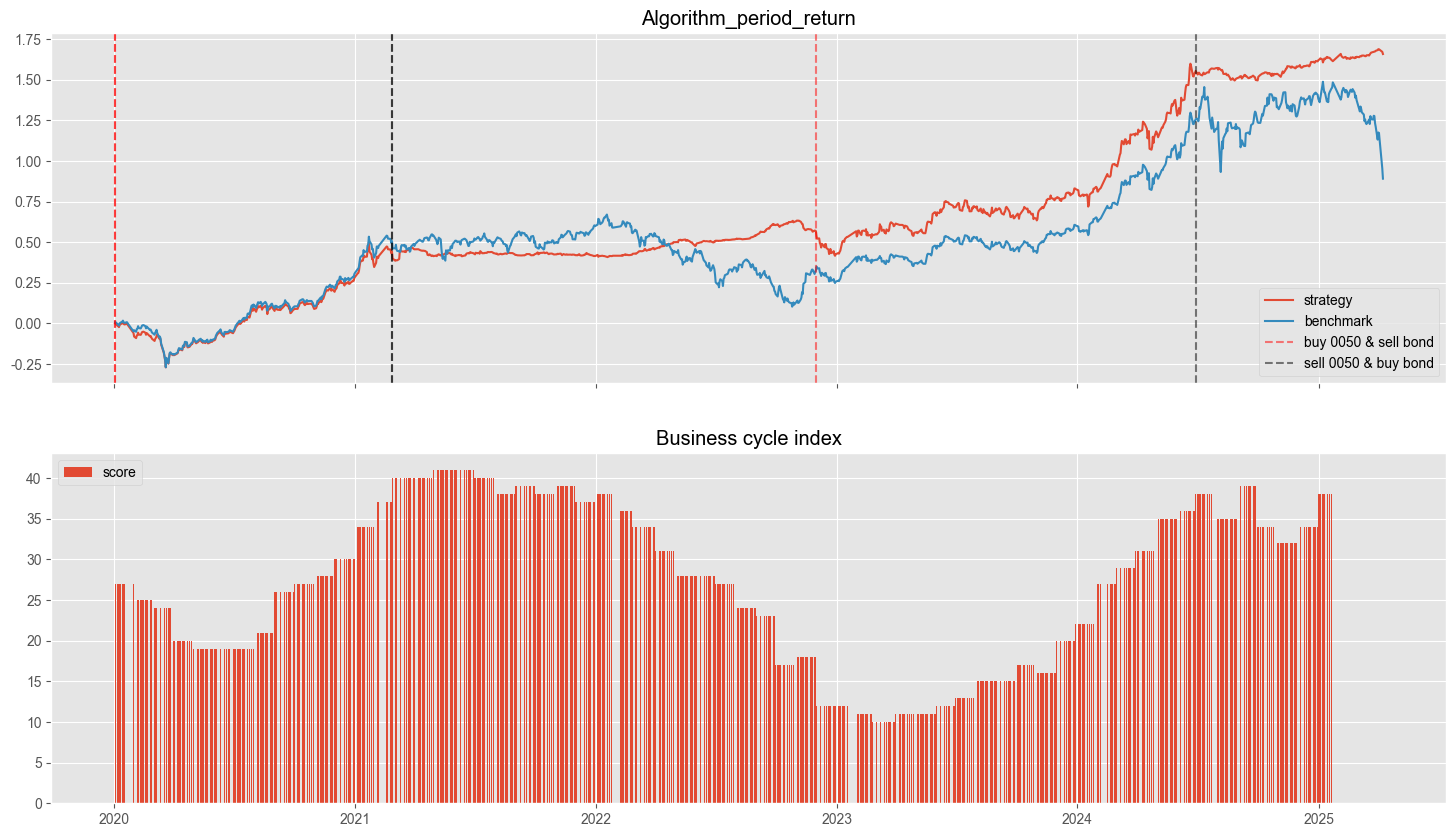

In [ ]:

def initialize(context, pool = pool):

  set_slippage(slippage.TW_Slippage(spread = 0.3 , volume_limit = 1))
  set_commission(commission.Custom_TW_Commission(min_trade_cost=20, discount=1.0, tax = 0.003))
  set_benchmark(symbol('0050'))

  context.i = 0
  context.pool  = pool
  context.state = False
  context.score = None
  context.hedge_state = None

  context.buy_date = []
  context.sell_date = []

  context.a = 0
  context.b = 0

  context.bond = symbol('00865B')
  context.stock = symbol('0050')


# short trem debt
def handle_data(context, data, score_data = df):

  backtest_date = data.current_dt.date()
  today_data = score_data[score_data['mdate'].shift(1) == pd.to_datetime(backtest_date)]
  context.score = today_data['val_shifted'].iloc[-1]

  record(score=context.score)

  if context.score <= 16 and context.state == False:
    order_target_percent(context.stock, 1.0)
    print(f"Date: {backtest_date}, Score: {context.score}, 買進 0050")
    context.buy_date.append(pd.to_datetime(backtest_date))
    context.state = True

    if context.hedge_state == True:
      order_target_percent(context.bond, 0)
      print(f"Date: {backtest_date}, Score: {context.score}，賣出債券")
      context.hedge_state = False


  if context.score >= 38 and context.state == True:
    order_target_percent(context.stock, 0)
    print(f"Date: {backtest_date}, Score: {context.score}, 賣出 0050")
    context.sell_date.append(pd.to_datetime(backtest_date))
    context.state = False

    if context.hedge_state == False :
      order_target_percent(context.bond, 1.0)
      print(f"Date: {backtest_date}, Score: {context.score}，買入債券避險")
      context.hedge_state = True



  if context.score > 16 and context.score < 38 and context.a == 0:
    context.a = 1
    print('進入景氣循環')
    if context.state == False:
      order_target_percent(context.stock, 1.0)
      print(f"Date: {backtest_date}, Score: {context.score}, 買進 0050")
      context.buy_date.append(pd.to_datetime(backtest_date))
      context.state = True

  # 因為 00685B 從 2019-11-25 才開始被交易
  if pd.to_datetime(backtest_date) >= pd.to_datetime('2019-11-25') and context.b == 0:
    context.b = 1
    context.hedge_state = False

# Cash
def handle_data_2(context, data, score_data = df):
  backtest_date = data.current_dt.date()
  today_data = score_data[score_data['mdate'].shift(1) == pd.to_datetime(backtest_date)]
  context.score = today_data['val_shifted'].iloc[-1]

  record(score=context.score)
  

  if context.score <= 16 and context.state == False:
    order_target_percent(context.stock, 1.0)
    print(f"Date: {backtest_date}, Score: {context.score}, 買進 0050")
    context.buy_date.append(pd.to_datetime(backtest_date))
    context.state = True

  if context.score >= 38 and context.state == True:
    order_target_percent(context.stock, 0)
    print(f"Date: {backtest_date}, Score: {context.score}, 賣出 0050")
    context.sell_date.append(pd.to_datetime(backtest_date))
    context.state = False

  if context.score > 16 and context.score < 38 and context.a == 0:
    context.a = 1
    print('進入景氣循環')
    if context.state == False:
      order_target_percent(context.stock, 1.0)
      print(f"Date: {backtest_date}, Score: {context.score}, 買進 0050")
      context.buy_date.append(pd.to_datetime(backtest_date))
      context.state = True

# long term debt
def handle_data_3(context, data, score_data = df):
  context.bond = symbol('00687B')
  backtest_date = data.current_dt.date()
  today_data = score_data[score_data['mdate'].shift(1) == pd.to_datetime(backtest_date)]
  context.score = today_data['val_shifted'].iloc[-1]

  record(score=context.score)

  if context.score <= 16 and context.state == False:
    order_target_percent(context.stock, 1.0)
    print(f"Date: {backtest_date}, Score: {context.score}, 買進 0050")
    context.buy_date.append(pd.to_datetime(backtest_date))
    context.state = True

    if context.hedge_state == True:
      order_target_percent(context.bond, 0)
      print(f"Date: {backtest_date}, Score: {context.score}，賣出債券")
      context.hedge_state = False


  if context.score >= 38 and context.state == True:
    order_target_percent(context.stock, 0)
    print(f"Date: {backtest_date}, Score: {context.score}, 賣出 0050")
    context.sell_date.append(pd.to_datetime(backtest_date))
    context.state = False

    if context.hedge_state == False :
      order_target_percent(context.bond, 1.0)
      print(f"Date: {backtest_date}, Score: {context.score}，買入債券避險")
      context.hedge_state = True



  if context.score > 16 and context.score < 38 and context.a == 0:
    context.a = 1
    print('進入景氣循環')
    if context.state == False:
      order_target_percent(context.stock, 1.0)
      print(f"Date: {backtest_date}, Score: {context.score}, 買進 0050")
      context.buy_date.append(pd.to_datetime(backtest_date))
      context.state = True

  # 因為 00685B 從 2019-11-25 才開始被交易
  if pd.to_datetime(backtest_date) >= pd.to_datetime('2019-11-25') and context.b == 0:
    context.b = 1
    context.hedge_state = False

# 0050 反一
def handle_data_4(context, data, score_data = df):
  context.bond = symbol('00664R')
  backtest_date = data.current_dt.date()
  today_data = score_data[score_data['mdate'].shift(1) == pd.to_datetime(backtest_date)]
  context.score = today_data['val_shifted'].iloc[-1]

  record(score=context.score)

  if context.score <= 16 and context.state == False:
    order_target_percent(context.stock, 1.0)
    print(f"Date: {backtest_date}, Score: {context.score}, 買進 0050")
    context.buy_date.append(pd.to_datetime(backtest_date))
    context.state = True

    if context.hedge_state == True:
      order_target_percent(context.bond, 0)
      print(f"Date: {backtest_date}, Score: {context.score}，賣出 0050 反一")
      context.hedge_state = False


  if context.score >= 38 and context.state == True:
    order_target_percent(context.stock, 0)
    print(f"Date: {backtest_date}, Score: {context.score}, 賣出 0050")
    context.sell_date.append(pd.to_datetime(backtest_date))
    context.state = False

    if context.hedge_state == False :
      order_target_percent(context.bond, 1.0)
      print(f"Date: {backtest_date}, Score: {context.score}，買入 0050反一")
      context.hedge_state = True



  if context.score > 16 and context.score < 38 and context.a == 0:
    context.a = 1
    print('進入景氣循環')
    if context.state == False:
      order_target_percent(context.stock, 1.0)
      print(f"Date: {backtest_date}, Score: {context.score}, 買進 0050")
      context.buy_date.append(pd.to_datetime(backtest_date))
      context.state = True

  # 因為 00685B 從 2019-11-25 才開始被交易
  if pd.to_datetime(backtest_date) >= pd.to_datetime('2019-11-25') and context.b == 0:
    context.b = 1
    context.hedge_state = False

# 50:50 (0050 短債)
def handle_data_5(context, data, score_data = df):

  backtest_date = data.current_dt.date()
  today_data = score_data[score_data['mdate'].shift(1) == pd.to_datetime(backtest_date)]
  context.score = today_data['val_shifted'].iloc[-1]

  record(score=context.score)

  if context.score <= 16 and context.state == False:
    order_target_percent(context.stock, 1.0)
    print(f"Date: {backtest_date}, Score: {context.score}, 買進 0050")
    context.buy_date.append(pd.to_datetime(backtest_date))
    context.state = True

    if context.hedge_state == True:
      order_target_percent(context.bond, 0)
      print(f"Date: {backtest_date}, Score: {context.score}，賣出債券")
      context.hedge_state = False


  if context.score >= 38 and context.state == True:
    order_target_percent(context.stock, 0.5)
    print(f"Date: {backtest_date}, Score: {context.score}, 賣出 0050")
    context.sell_date.append(pd.to_datetime(backtest_date))
    context.state = False

    if context.hedge_state == False :
      order_target_percent(context.bond, 0.5)
      print(f"Date: {backtest_date}, Score: {context.score}，買入債券避險")
      context.hedge_state = True



  if context.score > 16 and context.score < 38 and context.a == 0:
    context.a = 1
    print('進入景氣循環')
    if context.state == False:
      order_target_percent(context.stock, 1.0)
      print(f"Date: {backtest_date}, Score: {context.score}, 買進 0050")
      context.buy_date.append(pd.to_datetime(backtest_date))
      context.state = True

  # 因為 00685B 從 2019-11-25 才開始被交易
  if pd.to_datetime(backtest_date) >= pd.to_datetime('2019-11-25') and context.b == 0:
    context.b = 1
    context.hedge_state = False

def handle_data_6(context, data, score_data = df):
  if context.i == 0:
    order_target_percent(context.stock, 1.0)

  context.i += 1
  backtest_date = data.current_dt.date()
  today_data = score_data[score_data['mdate'].shift(1) == pd.to_datetime(backtest_date)]
  context.score = today_data['val_shifted'].iloc[-1]
  record(score=context.score)


def analyze(context, perf):
  plt.style.use('ggplot')
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), sharex=True)


  axes[0].plot(perf.index, perf['algorithm_period_return'], label = 'strategy')
  axes[0].plot(perf.index, perf['benchmark_period_return'], label = 'benchmark')

  for idx, i in enumerate(context.buy_date):
    if idx == 0:
      axes[0].axvline(x = i, color = 'red', label = 'buy 0050 & sell bond', linestyle = '--', alpha = 0.5)
    axes[0].axvline(x = i, color = 'red', linestyle = '--', alpha = 0.5)

  for idx, i in enumerate(context.sell_date):
    if idx == 0:
      axes[0].axvline(x = i, color = 'black', label = 'sell 0050 & buy bond', linestyle = '--', alpha = 0.5)
    axes[0].axvline(x = i, color = 'black', linestyle = '--', alpha = 0.5)

  axes[0].set_title(f'Algorithm_period_return')
  axes[0].legend()  

  axes[1].bar(perf.index, perf['score'], label='score')
  axes[1].set_title('Business cycle index')
  axes[1].legend()
  
  plt.show()



results = run_algorithm(
            start = pd.Timestamp('2020-01-01', tz = 'utc'),
            end = pd.Timestamp('2025-04-08', tz = 'utc'),
            initialize = initialize,
            handle_data = handle_data,
            analyze = analyze,
            bundle = 'tquant',
            capital_base = 1e5)

Start date,2020-01-02
End date,2025-04-08
Total months,60
,Backtest
Annual return,21.324%
Cumulative returns,165.905%
Annual volatility,14.849%
Sharpe ratio,1.38
Calmar ratio,0.77
Stability,0.90
Max drawdown,-27.601%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.60,2020-01-14,2020-03-19,2020-07-13,117
1,13.26,2022-11-02,2022-12-29,2023-05-25,132
2,10.11,2021-01-21,2021-01-29,2022-04-28,305
3,7.70,2024-04-09,2024-04-22,2024-05-13,24
4,7.05,2023-07-14,2023-10-31,2023-11-15,85


Top 10 long positions of all time,max
sid,
0050,104.20%
00865B,100.91%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
0050,104.20%
00865B,100.91%


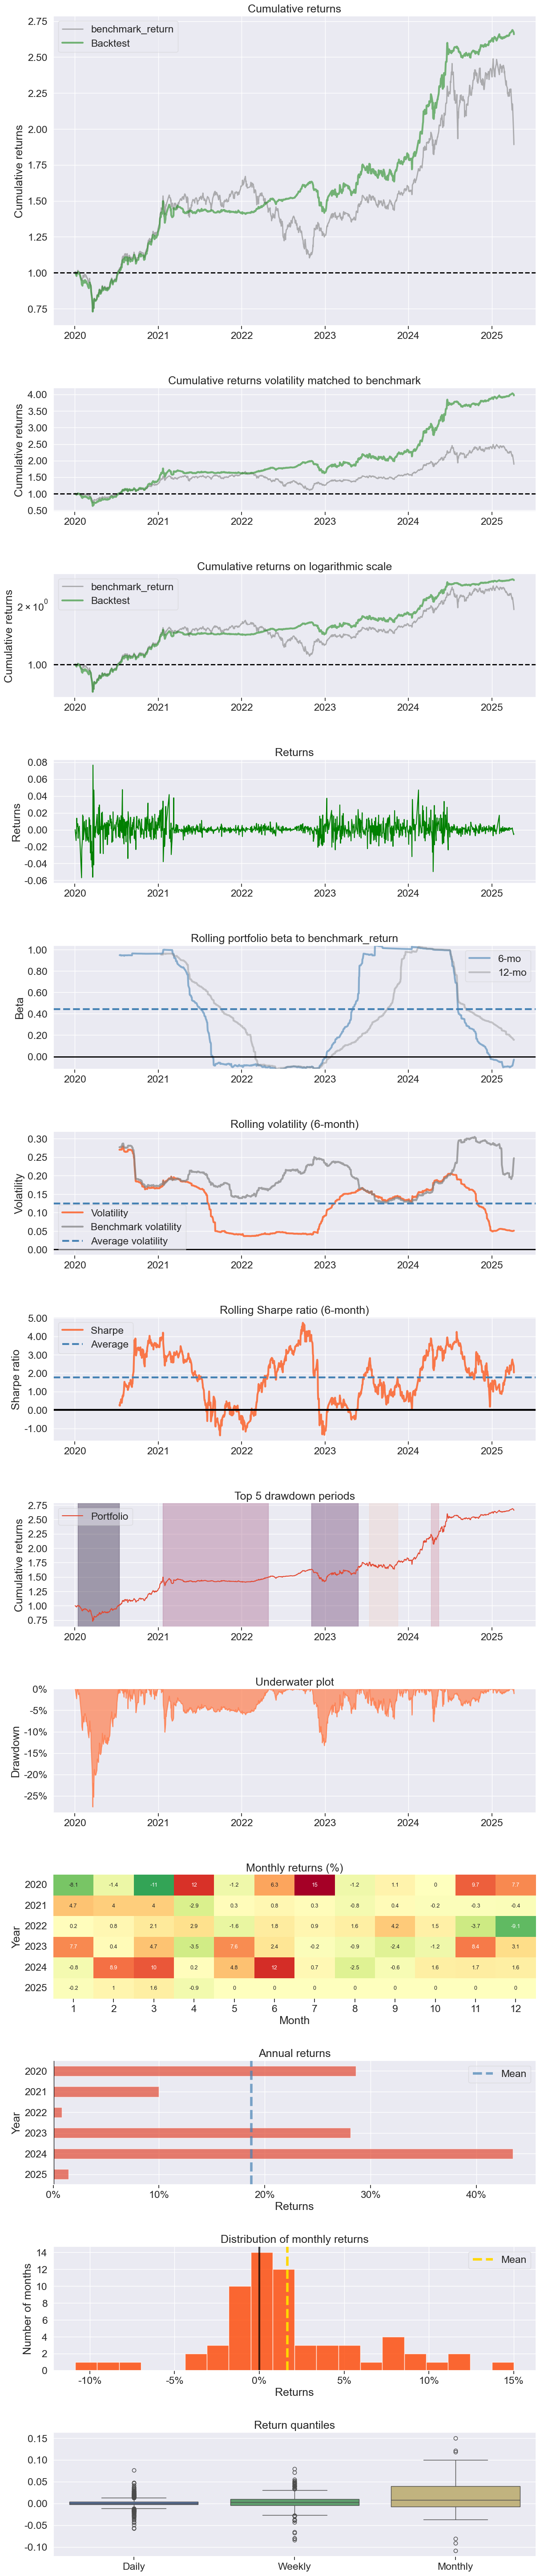

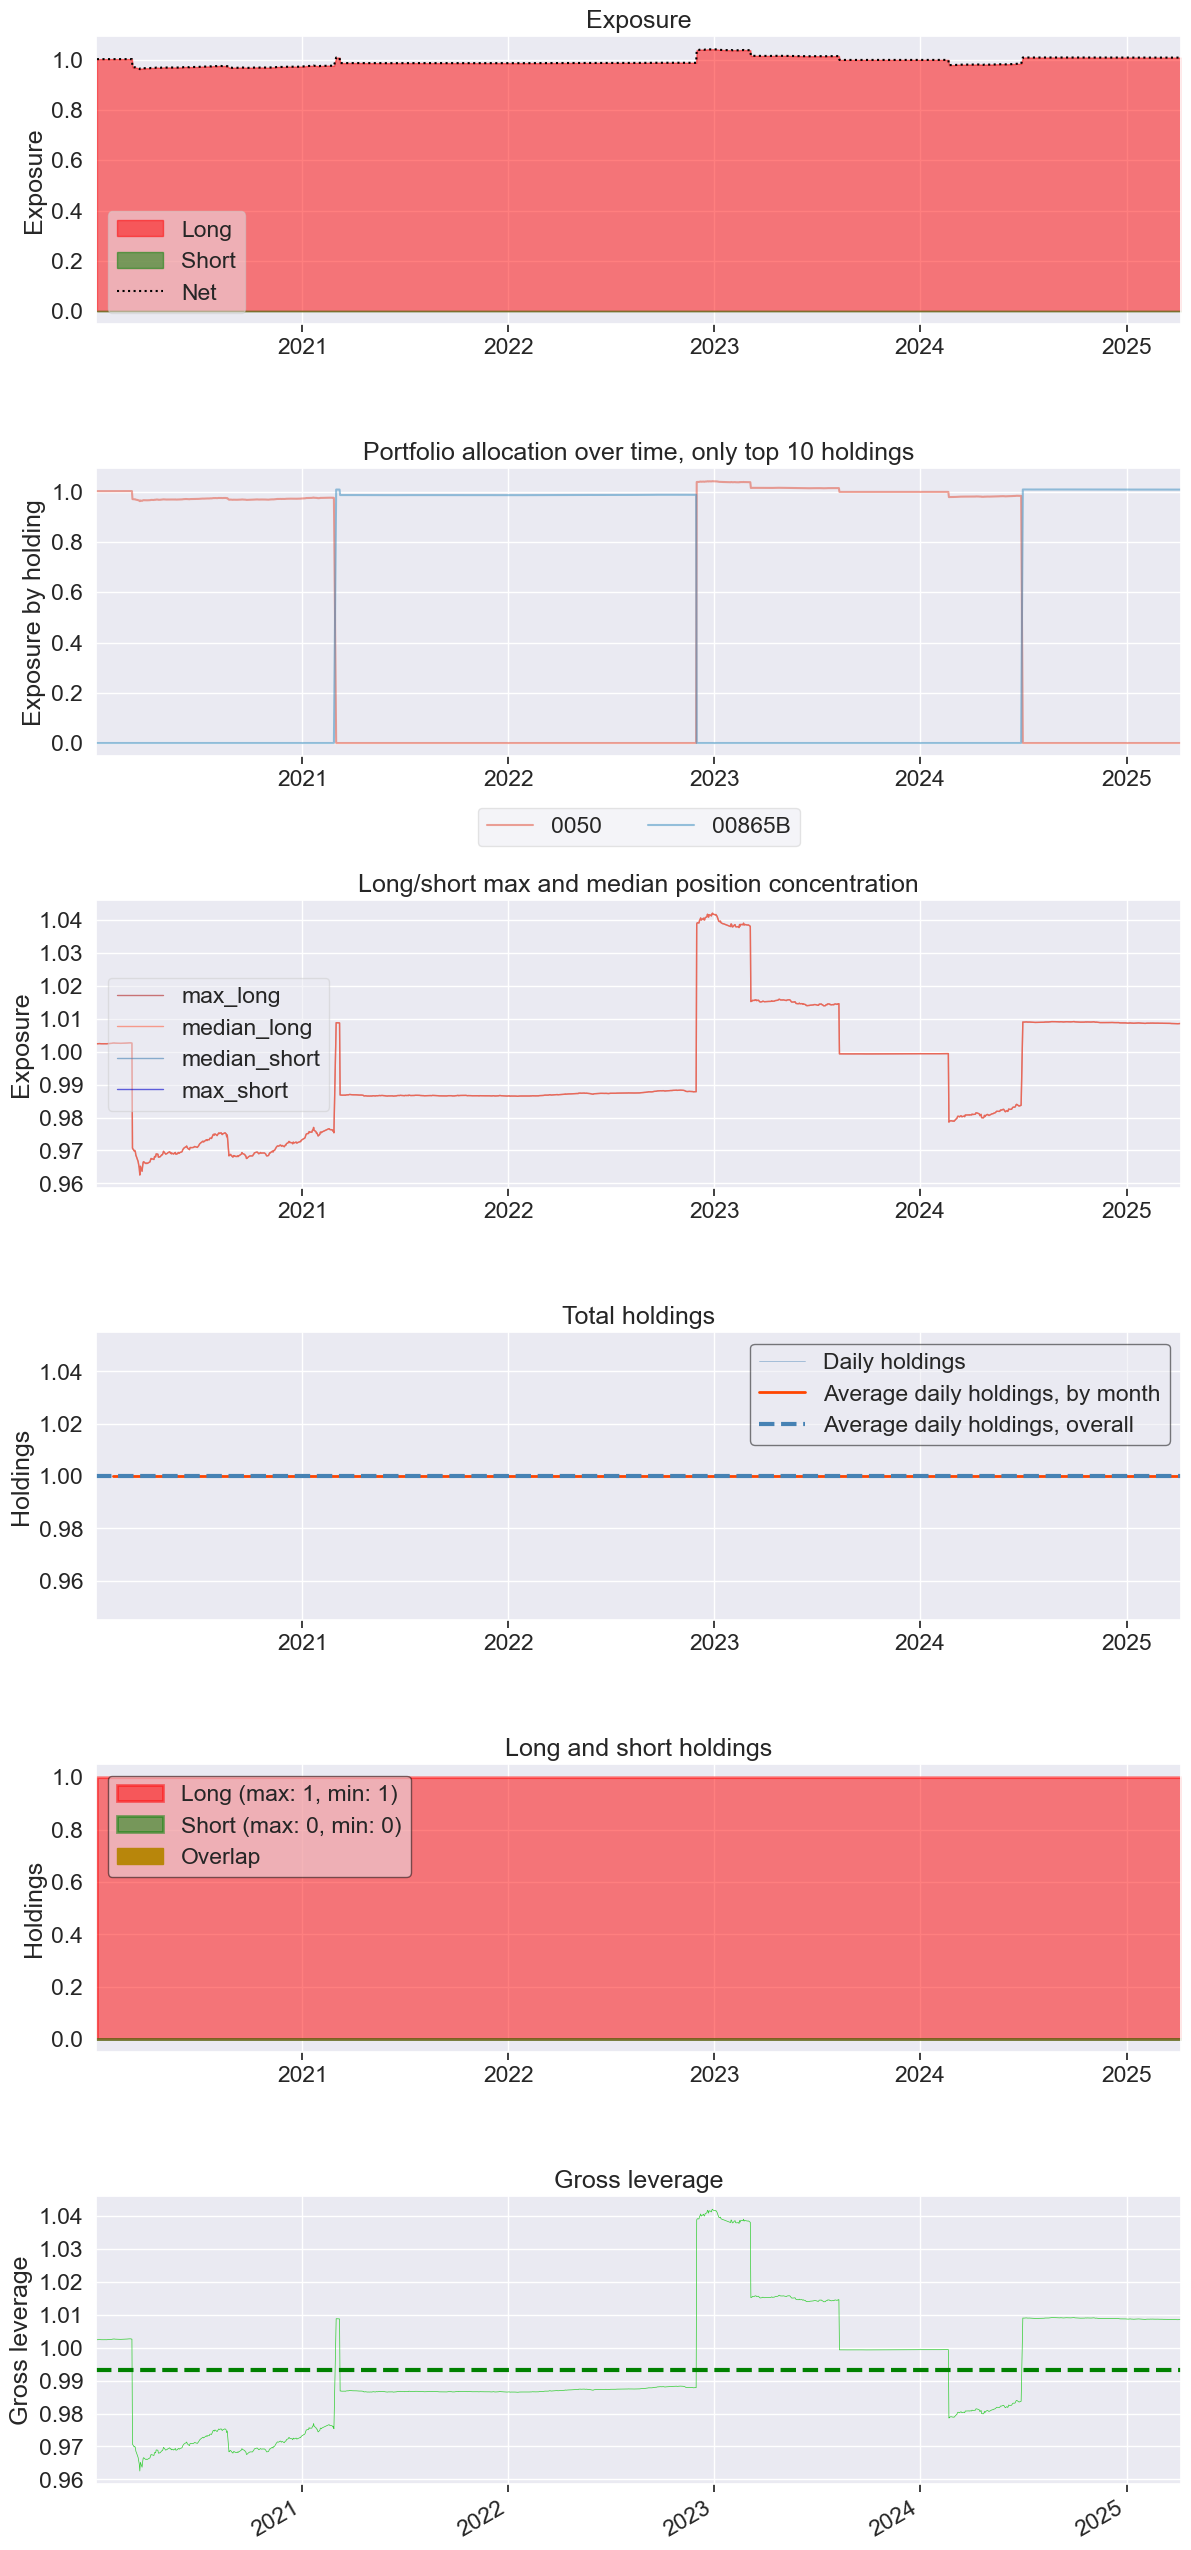

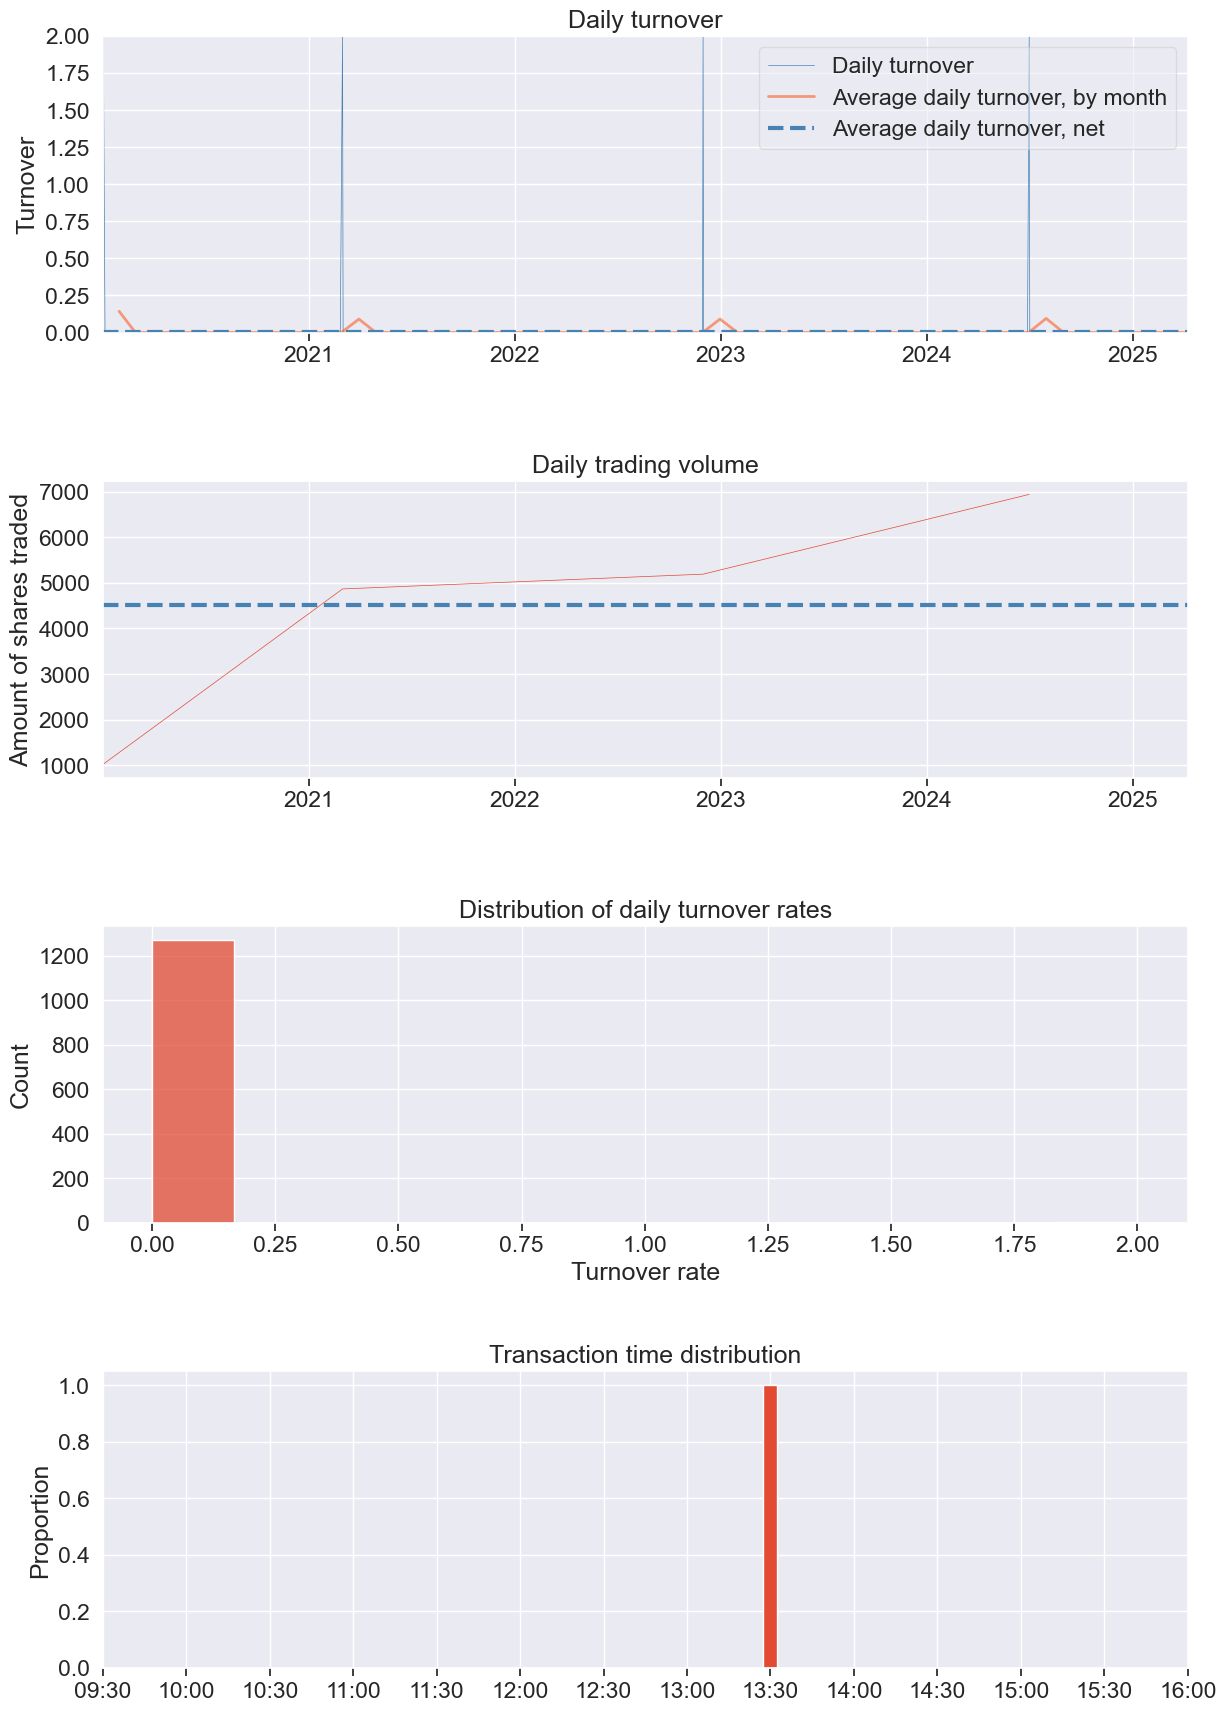

In [167]:
import pyfolio
from pyfolio.utils import extract_rets_pos_txn_from_zipline
plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans CJK TC', 'SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return
pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )

In [132]:
positions.loc['2024-12-06 00:00:00+00:00':].head(10)

sid,Equity(0 [0050]),Equity(1 [00632R]),cash
index,,,
2024-12-06 00:00:00+00:00,0.0,199174.72,-2180.69
2024-12-09 00:00:00+00:00,0.0,199174.72,-2180.69
2024-12-10 00:00:00+00:00,0.0,199174.72,-2180.69
2024-12-11 00:00:00+00:00,0.0,1403938.88,-2180.69
2024-12-12 00:00:00+00:00,0.0,1389365.12,-2180.69
2024-12-13 00:00:00+00:00,0.0,1393615.80,-2180.69
2024-12-16 00:00:00+00:00,0.0,1397259.24,-2180.69
2024-12-17 00:00:00+00:00,0.0,1388150.64,-2180.69
2024-12-18 00:00:00+00:00,0.0,1386328.92,-2180.69


進入景氣循環
Date: 2020-01-02, Score: 27.0, 買進 0050
Date: 2021-02-26, Score: 40.0, 賣出 0050
Date: 2021-02-26, Score: 40.0，買入債券避險
Date: 2022-11-30, Score: 12.0, 買進 0050
Date: 2022-11-30, Score: 12.0，賣出債券
Date: 2024-06-28, Score: 38.0, 賣出 0050
Date: 2024-06-28, Score: 38.0，買入債券避險
進入景氣循環
Date: 2020-01-02, Score: 27.0, 買進 0050
Date: 2021-02-26, Score: 40.0, 賣出 0050
Date: 2022-11-30, Score: 12.0, 買進 0050
Date: 2024-06-28, Score: 38.0, 賣出 0050
進入景氣循環
Date: 2020-01-02, Score: 27.0, 買進 0050
Date: 2021-02-26, Score: 40.0, 賣出 0050
Date: 2021-02-26, Score: 40.0，買入債券避險
Date: 2022-11-30, Score: 12.0, 買進 0050
Date: 2022-11-30, Score: 12.0，賣出債券
Date: 2024-06-28, Score: 38.0, 賣出 0050
Date: 2024-06-28, Score: 38.0，買入債券避險
進入景氣循環
Date: 2020-01-02, Score: 27.0, 買進 0050
Date: 2021-02-26, Score: 40.0, 賣出 0050
Date: 2021-02-26, Score: 40.0，買入 0050反一
Date: 2022-11-30, Score: 12.0, 買進 0050
Date: 2022-11-30, Score: 12.0，賣出 0050 反一
Date: 2024-06-28, Score: 38.0, 賣出 0050
Date: 2024-06-28, Score: 38.0，買入 0050反一
進入景氣循環
Da

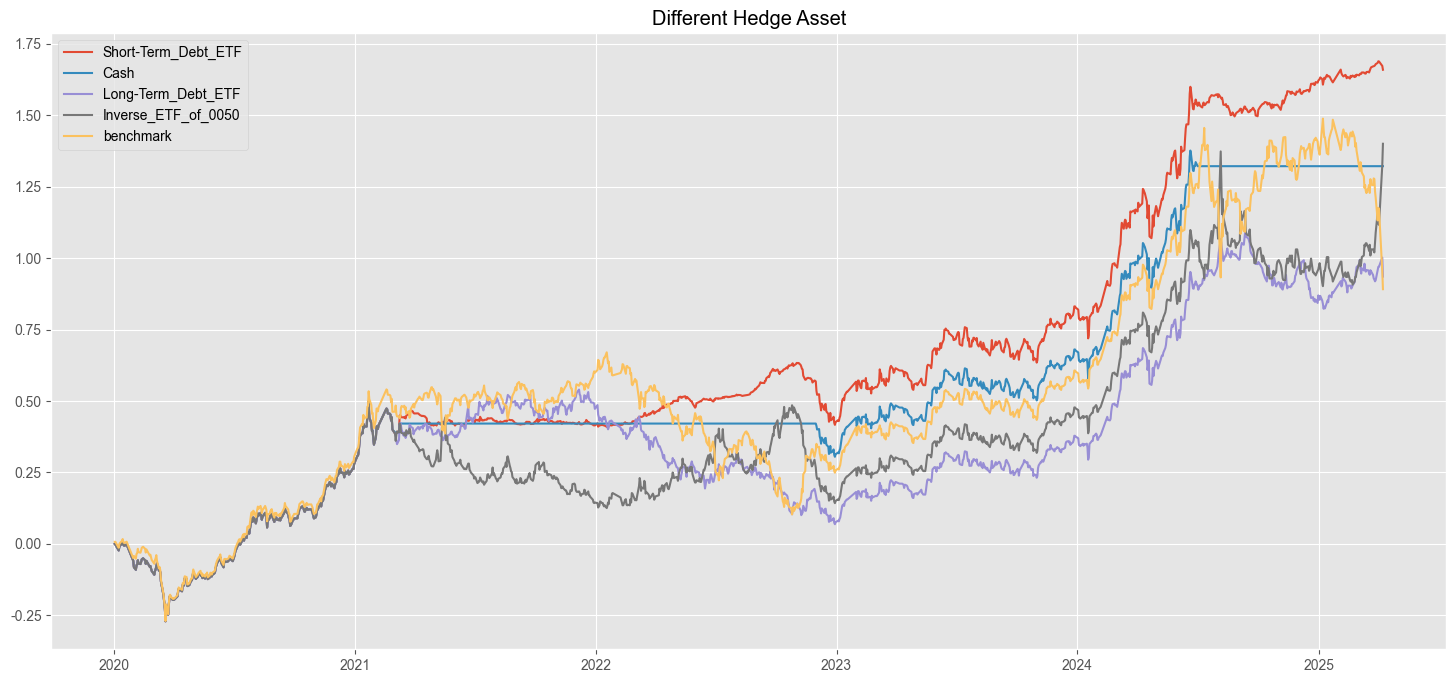

In [168]:
def initialize_2(context, pool = pool):
  set_slippage(slippage.TW_Slippage(spread = 0.3 , volume_limit = 1))
  set_commission(commission.Custom_TW_Commission(min_trade_cost=20, discount=1.0, tax = 0.003))
  set_benchmark(symbol('0050'))

  context.i = 0
  context.pool  = pool
  context.state = False
  context.score = None
  context.hedge_state = None

  context.buy_date = []
  context.sell_date = []

  context.a = 0
  context.b = 0

  context.bond = symbol('00865B')
  context.stock = symbol('0050')


metrods = [handle_data, handle_data_2, handle_data_3, handle_data_4, handle_data_5]
label = ['Short-Term_Debt_ETF', 'Cash', 'Long-Term_Debt_ETF', 'Inverse_ETF_of_0050', '50:50(short-term bond)']
algo = pd.DataFrame()

for idx, metrod in enumerate(metrods):

  def analyze_2(context, perf):
    algo[f'{label[idx]}'] = perf['algorithm_period_return']
    if idx == 0:
      algo['benchmark'] = perf['benchmark_period_return']


  results = run_algorithm(
            start = pd.Timestamp('2020-01-01', tz = 'utc'),
            end = pd.Timestamp('2025-04-08', tz = 'utc'),
            initialize = initialize_2,
            handle_data = metrod,
            analyze = analyze_2,
            bundle = 'tquant',
            capital_base = 1e5)
  


plt.figure(figsize = (18, 8))
plt.plot(algo.index, algo[f'{label[0]}'], label = label[0])
plt.plot(algo.index, algo[f'{label[1]}'], label = label[1])
plt.plot(algo.index, algo[f'{label[2]}'], label = label[2])
plt.plot(algo.index, algo[f'{label[3]}'], label = label[3])
#plt.plot(algo.index, algo[f'{label[4]}'], label = label[4])
plt.plot(algo.index, algo['benchmark'], label = 'benchmark')
plt.title('Different Hedge Asset')
plt.legend()
plt.show()